# Image generation with DCGAN

This notebook shows how to implement a DCGAN based on Gluon. DCGAN is an extension of [GANs](https://arxiv.org/abs/1406.2661), where the generator and discriminator are Convolutional Neural Networks (CNN) (see [DCGAN Paper](https://arxiv.org/pdf/1511.06434.pdf)). 
DCGAN learns to draw images based on features it learns from different layers in the network. It can be used for generating natural images. This notebook is based on the DCGAN example from the [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). 


In this example, you will learn to:

* Create a DCGAN - Define a Generator that creates images from random numbers. Define a Discriminator that determines if the image created by the Generator is real or fake.

* retrieve images of a dataset, pre-process them, and load them for training using a Data Loader.

* write a training loop for the GAN. 

* visualize images through the training process.

## Prerequisites

First, we will go ahead and install the CUDA-enabled version of MXNet "mxnet-cu92" to be able to execute our example on GPU. We are using [MXNet v1.4.1](http://mxnet.incubator.apache.org/versions/master/install/index.html).

To execute on CPU, install MXNet using
`pip install mxnet`. CUDA is not required in this case. Training time may be significantly larger when executed on CPU.

In [1]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install mxnet-cu92

--2019-06-17 23:11:40--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?NWsdOZIWN9pOLY6XOlYZGJ1TOaIN1NHSazuXbqD6pjJtRCzfms-sg0hMvwp5K4K8bdZbUe3rofHevRvBanEs6gDL0F0zD758vQda3vRcgVFSkUgAqnGI7F7csbM7iDvA7sW6WYOdpDyhjlXpDg22H6YpP-fz-I-eqm8MQZx2mj1OX1tTtHq12inmgT8u1Z6VnbIVPPa701VU8V0tKuk [following]
--2019-06-17 23:11:40--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?NWsdOZIWN9pOLY6XOlYZGJ1TOaIN1NHSazuXbqD6pjJtRCzfms-sg0hMvwp5K4K8bdZbUe3rofHevRvBanEs6gDL0F0zD758vQda3vRcgVFSkUgAqnGI7F

In [2]:
!export PATH=/usr/local/cuda-9.2/bin:$PATH
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


If ipywidgets is not available, execute the following step

In [3]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Next, we import all the libraries required to execute our example.

We make use of [MXNet's Gluon API ](http://mxnet.incubator.apache.org/versions/master/gluon/index.html), which is a simple interface that makes it easy build and train models.

In [4]:
from __future__ import print_function
from datetime import datetime
import logging
logging.getLogger().setLevel(logging.INFO)
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

## Hyperparameters

We then set some hyperparameters for training.

Every dataset is divided into one or more batches. The `batch_size` is the number of samples to process before updating the model. 

One scan through the entire dataset is called an `epoch`.

A `context` describes the device type and id on which computation should be carried on.

`z_dim` - how many random numbers we want to produce a single image from.

`lr` - learning rate used for training the model.

`beta` - The beta value used for `Adam Optimizer`. The [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) suggestes to use `Adam Optimizer` with `beta = 0.5`.

In [5]:
z_dim        = 100
ctx = [mx.gpu(i) for i in range(mx.context.num_gpus())] if mx.context.num_gpus() > 0 else [mx.cpu()]
epochs = 150
lr = 0.0002
beta = 0.5
batch_size = 64 * len(ctx) # We will load 64 samples on each GPU/CPU that we have chosen in the context.

In [6]:
logging.info('Total devices available to run on : %s' %(ctx))

INFO:root:Total devices available to run on : [gpu(0), gpu(1), gpu(2), gpu(3), gpu(4), gpu(5), gpu(6), gpu(7)]


## Download the dataset


You can plug in any dataset of your choice and execute this example. You are given an option to choose from any of the datasets in the dropdown below. 

To try out this example with your own dataset, pack the folder containing the images of your dataset into a .tgz file and modify the below code to unpack the .tgz file to automatically take your local dataset. Alternatively, mention the URL where the data is stored.

In [7]:
w = widgets.Dropdown(
    options=['Faces', 'Cartoon', 'Classroom', 'Flowers'],
    value='Faces',
    description='Dataset:',
    disabled=False,
    button_style=''
)

display(w)


Dropdown(description='Dataset:', options=('Faces', 'Cartoon', 'Classroom', 'Flowers'), value='Faces')

In [8]:
data_dir = '/tmp/' + w.value

In [9]:
data_url = 'https://s3.amazonaws.com/mxnet-conf-data/GAN_Meetup/'+w.value+'.tgz'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
data_file = utils.download(data_url)
with tarfile.open(data_file) as tar:
    tar.extractall(path=data_dir)

```visualize``` is a utility method to plot the images using ```matplotlib```. 
We will use this method to show the images generated by the GAN network as well.

In [10]:
def visualize(img_array):
    plt.imshow(((img_array.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

## Prepare the data

Let's start by preparing the images from the selected dataset. This is done so that all images are similar in terms of shape, color etc.

The first step is to resize the images to the same size of 64x64 as our GAN below takes inputs of size 64x64.

Most images saved are of the format `(height, width, channels)`, but for further processing by our model, we need a format `(channels, height, width)`, therefore, we transpose the image to get the  format that MXNet works with. More about reshape and transpose [here](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/reshape_transpose.html).

Each pixel in our 64x64 image is represented by a number between 0-255, that represents the intensity of the pixel. However, we want to input numbers between -1 and 1 into our DCGAN, as suggested by the research paper. To rescale our pixels to be in the range of -1 to 1, we'll divide each pixel by (255/2). This put our images on a scale of 0-2. We can then subtract by 1, to get them in the range of -1 to 1.

We need to add 3 channels to our images. Typically when we are working with images, the 3 channels represent the red, green, and blue components. If the onput images are black and white (only 1 channel), we use `Tile` to pad the other channels with 0's. 

We then reshape the image to the `(batch, channel, height, width)` where batch is 1 (as we are processing 1 image) and return the result.

In [11]:
def transform(data, width=64, height=64):
    data = mx.image.imresize(data, width, height)
    data = nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [12]:
def get_files(data_dir):
    images    = []
    filenames = []
    for path, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            images.append(img_arr)
            filenames.append(path + "/" + fname)
    return images, filenames        

## Load the dataset

[Reference](http://mxnet.incubator.apache.org/versions/master/tutorials/gluon/datasets.html)

One of the most critical steps for model training and inference is loading the data.

Dataset objects are used to represent collections of data, and include methods to load and parse the data.

A DataLoader is used to create mini-batches of samples from a Dataset, and provides a convenient iterator interface for looping these batches. It’s typically much more efficient to pass a mini-batch of data through a neural network than a single sample at a time, because the computation can be performed in parallel.


We split the images into a batches and load them, with 64 * len(ctx) images in each batch (`batch_size`) mentioned in the hyperparameters above). Every time we iterate, we'll get a 4 dimensional array with size (64 * len(ctx), 3, 64, 64), representing a batch of 64 * len(ctx) images.


In [13]:
train_images, train_filenames = get_files(data_dir)

train_data = gluon.data.ArrayDataset(nd.concatenate(train_images))
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

Let's look at some samples of the training dataset

INFO:root:Total samples in the dataset : 13233


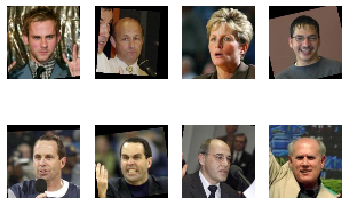

In [14]:
logging.info('Total samples in the dataset : %d' %(len(train_data)))
num_image = 8
for i in range(num_image):
    plt.subplot(2,4,i+1)
    visualize(train_data[i])
plt.show()

## Create the model

### Generator
Define the Generator model. Architecture is taken from the DCGAN implementation in [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). The Generator consist of  4 layers where each layer involves a strided convolution, batch normalization, and rectified nonlinearity. It takes as input random noise and produces an `(64,64,3)` output image.



![alt text](https://github.com/yash1/mxnet-notebooks/raw/a2795a0cdc9e111b42b60fa6b1a4e6219df72afc/python/tutorials/dcgan-model.png)

Source: https://arxiv.org/abs/1511.06434


Our generator image starts with random numbers as input.

We then apply a Deconvolution layer, batch normalization and ReLU activation.

We repeat this process 4 times, applying a (2,2) stride and (1,1) pad at each Deconvolutional layer, which doubles the size of our image at each layer. We also reduce half the number of filters at each layer, reducing dimensionality at each layer. Ultimatley, our output layer is a 64x64x3 layer, representing the size and channels of our image. We use tanh activation instead of relu on the last layer, as recommended by the research on DCGANs. The output of neurons in the final out layer represents the pixels of generated image.

In [15]:
class Generator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():
            self.prev = nn.HybridSequential()
            self.prev.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            
            self.G = nn.HybridSequential()
            self.G.add(nn.Conv2DTranspose(channels=64 * 8, kernel_size=4, strides=1, padding=0, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 1, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=3, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.Activation('tanh'))

    def hybrid_forward(self, F, x):
        x = self.prev(x)
        x = F.reshape(x, (0, -1, 1, 1))
        return self.G(x)

### Discriminator

The discriminator works exactly the same way but in reverse - using convolutional layers instead of deconvolutional layers to take an image and determine if it is real or fake.

We start off by giving input images to the discriminator.

The discriminator then goes through a series of 4 convolutional layers, each with a 4x4 kernel, 2x2 stride, and 1x1 pad. These layers half the size of the image (which starts at 64x64) at each convolutional layer. Our model also increases dimensionality at each layer by doubling the number of filters per convolutional layer.

Finally, we flatten the neural net to get one number as the final output of discriminator network.

In [16]:
class Discriminator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        with self.name_scope():
            self.D = nn.HybridSequential()
            self.D.add(nn.Conv2D(channels=64 * 1, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 8, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Dense(units=1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.D.add(nn.Dense(units=1))

    def hybrid_forward(self, F, x):
          return self.D(x)

Initialize Generator and Discriminator and define correspoing trainer function.

Trainer applies an Optimizer on a set of Parameters. It takes the parameters to be optimized, optimizer to use, and parameters to the optimizer as arguments.

Here, we use the `adam` optimizer for gradient decent and set hyperparameters, `lr` and `beta1` based on the values used in the DCGAN paper. 

In [17]:
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(sigma=0.002), ctx=ctx)

discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(sigma=0.002), ctx=ctx)

g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

## Training the model

Create vectors with real (=1) and fake labels (=0).

In [18]:
real_label = nd.ones((batch_size,))
# Split the data across multiple GPUs
real_label = gluon.utils.split_and_load(data = real_label, ctx_list=ctx, even_split=False)

fake_label = nd.zeros((batch_size,))
# Split the data across multiple GPUs
fake_label = gluon.utils.split_and_load(data = fake_label, ctx_list=ctx, even_split=False)

Define a loss function to determine by how much the Discriminator made a mistake while detecting a real/fake image.

In [19]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

Create random input for the Generator to start with

In [20]:
def create_generator_input():  
    #create random noise
    z      = nd.random_normal(0, 1, shape=(batch_size, z_dim, 1, 1))
    z = gluon.utils.split_and_load(data=z, ctx_list=ctx, even_split=False)
    return z

Define a custom accuracy metric. If the output of the Discriminator is greater than 0.5, then consider as a real image and compare it with the label to determine accuracy.

In [21]:
def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

Define the training loop. 
1. The discriminator receives `real_data` and `loss` measures how many real images have been identified as real
2. The discriminator receives `fake_image` from the Generator and `loss` measures how many fake images have been identified as fake
3. Update Discriminator.
4. The updated discriminator receives `fake_image` and `loss` measures how many fake images have been been identified as real.
5. Update Generator

INFO:root:Epoch 0
INFO:root:speed: 104.0057532691594 samples/s
INFO:root:discriminator loss = 1.386515, generator loss = 0.735627, binary training acc = 0.500000 at iter 1 epoch 0
INFO:root:speed: 3810.067611251273 samples/s
INFO:root:discriminator loss = 1.433970, generator loss = 0.752097, binary training acc = 0.506929 at iter 21 epoch 0


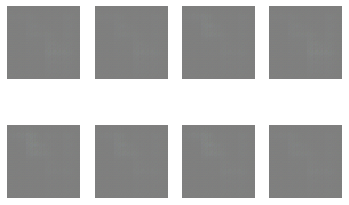

INFO:root:Epoch end. Total time for this epoch : 9.341738 (seconds)
INFO:root:Epoch 1
INFO:root:speed: 2969.800662972423 samples/s
INFO:root:discriminator loss = 1.332171, generator loss = 0.765927, binary training acc = 0.514648 at iter 1 epoch 1
INFO:root:speed: 4256.522385811352 samples/s
INFO:root:discriminator loss = 1.267341, generator loss = 0.834486, binary training acc = 0.537528 at iter 21 epoch 1
INFO:root:Epoch end. Total time for this epoch : 3.905225 (seconds)
INFO:root:Epoch 2
INFO:root:speed: 2618.939986487508 samples/s
INFO:root:discriminator loss = 1.275050, generator loss = 0.832537, binary training acc = 0.536133 at iter 1 epoch 2
INFO:root:speed: 3801.4009937707883 samples/s
INFO:root:discriminator loss = 1.336102, generator loss = 0.829020, binary training acc = 0.553618 at iter 21 epoch 2
INFO:root:Epoch end. Total time for this epoch : 3.740272 (seconds)
INFO:root:Epoch 3
INFO:root:speed: 4063.3098734924483 samples/s
INFO:root:discriminator loss = 1.129107, gene

INFO:root:Epoch end. Total time for this epoch : 3.622866 (seconds)
INFO:root:Epoch 21
INFO:root:speed: 3396.847587547592 samples/s
INFO:root:discriminator loss = 1.131080, generator loss = 1.069815, binary training acc = 0.750977 at iter 1 epoch 21
INFO:root:speed: 3889.7699593359716 samples/s
INFO:root:discriminator loss = 1.311854, generator loss = 0.915486, binary training acc = 0.705869 at iter 21 epoch 21
INFO:root:Epoch end. Total time for this epoch : 3.616490 (seconds)
INFO:root:Epoch 22
INFO:root:speed: 3904.664810838232 samples/s
INFO:root:discriminator loss = 1.226445, generator loss = 1.088934, binary training acc = 0.674805 at iter 1 epoch 22
INFO:root:speed: 3778.3929664173525 samples/s
INFO:root:discriminator loss = 1.192289, generator loss = 1.401646, binary training acc = 0.643043 at iter 21 epoch 22
INFO:root:Epoch end. Total time for this epoch : 3.652294 (seconds)
INFO:root:Epoch 23
INFO:root:speed: 4083.1653433117335 samples/s
INFO:root:discriminator loss = 1.1112

INFO:root:Epoch end. Total time for this epoch : 3.639097 (seconds)
INFO:root:Epoch 41
INFO:root:speed: 3776.3863672732964 samples/s
INFO:root:discriminator loss = 1.115807, generator loss = 1.441877, binary training acc = 0.716797 at iter 1 epoch 41
INFO:root:speed: 3664.3539647843945 samples/s
INFO:root:discriminator loss = 1.074472, generator loss = 1.610826, binary training acc = 0.718750 at iter 21 epoch 41
INFO:root:Epoch end. Total time for this epoch : 3.667935 (seconds)
INFO:root:Epoch 42
INFO:root:speed: 3996.396512547571 samples/s
INFO:root:discriminator loss = 0.852579, generator loss = 1.662097, binary training acc = 0.873047 at iter 1 epoch 42
INFO:root:speed: 3907.8836087828417 samples/s
INFO:root:discriminator loss = 0.830939, generator loss = 1.855439, binary training acc = 0.760603 at iter 21 epoch 42
INFO:root:Epoch end. Total time for this epoch : 3.606490 (seconds)
INFO:root:Epoch 43
INFO:root:speed: 3684.4407293789845 samples/s
INFO:root:discriminator loss = 1.017

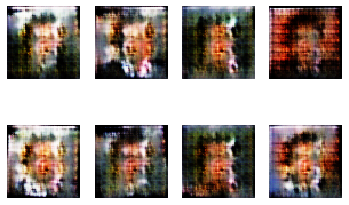

INFO:root:Epoch end. Total time for this epoch : 4.131826 (seconds)
INFO:root:Epoch 51
INFO:root:speed: 3821.6416865535916 samples/s
INFO:root:discriminator loss = 0.656634, generator loss = 2.130893, binary training acc = 0.914062 at iter 1 epoch 51
INFO:root:speed: 3706.7312819432914 samples/s
INFO:root:discriminator loss = 1.033264, generator loss = 1.756328, binary training acc = 0.789481 at iter 21 epoch 51
INFO:root:Epoch end. Total time for this epoch : 3.486274 (seconds)
INFO:root:Epoch 52
INFO:root:speed: 3711.5360916147165 samples/s
INFO:root:discriminator loss = 0.899510, generator loss = 1.693180, binary training acc = 0.828125 at iter 1 epoch 52
INFO:root:speed: 4698.348724052228 samples/s
INFO:root:discriminator loss = 1.172579, generator loss = 1.614217, binary training acc = 0.772042 at iter 21 epoch 52
INFO:root:Epoch end. Total time for this epoch : 3.488097 (seconds)
INFO:root:Epoch 53
INFO:root:speed: 3714.110177171755 samples/s
INFO:root:discriminator loss = 0.7034

INFO:root:Epoch end. Total time for this epoch : 3.687390 (seconds)
INFO:root:Epoch 71
INFO:root:speed: 3808.682350812909 samples/s
INFO:root:discriminator loss = 0.662770, generator loss = 1.598521, binary training acc = 0.855469 at iter 1 epoch 71
INFO:root:speed: 4033.7800385066917 samples/s
INFO:root:discriminator loss = 0.846485, generator loss = 2.012657, binary training acc = 0.817615 at iter 21 epoch 71
INFO:root:Epoch end. Total time for this epoch : 3.439261 (seconds)
INFO:root:Epoch 72
INFO:root:speed: 3793.986548249806 samples/s
INFO:root:discriminator loss = 1.173425, generator loss = 1.681939, binary training acc = 0.620117 at iter 1 epoch 72
INFO:root:speed: 3884.928619885559 samples/s
INFO:root:discriminator loss = 0.772757, generator loss = 2.147833, binary training acc = 0.818034 at iter 21 epoch 72
INFO:root:Epoch end. Total time for this epoch : 3.596350 (seconds)
INFO:root:Epoch 73
INFO:root:speed: 4529.237580619988 samples/s
INFO:root:discriminator loss = 0.690194

INFO:root:Epoch end. Total time for this epoch : 3.412572 (seconds)
INFO:root:Epoch 91
INFO:root:speed: 3953.0738452702653 samples/s
INFO:root:discriminator loss = 0.739863, generator loss = 2.085385, binary training acc = 0.882812 at iter 1 epoch 91
INFO:root:speed: 4571.516622565476 samples/s
INFO:root:discriminator loss = 0.978318, generator loss = 1.865570, binary training acc = 0.758324 at iter 21 epoch 91
INFO:root:Epoch end. Total time for this epoch : 3.501484 (seconds)
INFO:root:Epoch 92
INFO:root:speed: 4163.653976877245 samples/s
INFO:root:discriminator loss = 0.781105, generator loss = 1.774811, binary training acc = 0.813477 at iter 1 epoch 92
INFO:root:speed: 3904.8494107678293 samples/s
INFO:root:discriminator loss = 0.698370, generator loss = 2.300320, binary training acc = 0.814779 at iter 21 epoch 92
INFO:root:Epoch end. Total time for this epoch : 3.594260 (seconds)
INFO:root:Epoch 93
INFO:root:speed: 4021.9945274237502 samples/s
INFO:root:discriminator loss = 0.6918

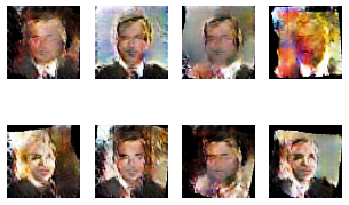

INFO:root:Epoch end. Total time for this epoch : 3.859930 (seconds)
INFO:root:Epoch 101
INFO:root:speed: 3511.1518104437737 samples/s
INFO:root:discriminator loss = 0.836176, generator loss = 1.717021, binary training acc = 0.759766 at iter 1 epoch 101
INFO:root:speed: 4636.070844451353 samples/s
INFO:root:discriminator loss = 0.902983, generator loss = 1.653490, binary training acc = 0.830543 at iter 21 epoch 101
INFO:root:Epoch end. Total time for this epoch : 3.492840 (seconds)
INFO:root:Epoch 102
INFO:root:speed: 3792.298173149088 samples/s
INFO:root:discriminator loss = 0.699082, generator loss = 1.907677, binary training acc = 0.817383 at iter 1 epoch 102
INFO:root:speed: 3546.119133997262 samples/s
INFO:root:discriminator loss = 0.629157, generator loss = 2.048689, binary training acc = 0.836728 at iter 21 epoch 102
INFO:root:Epoch end. Total time for this epoch : 3.687028 (seconds)
INFO:root:Epoch 103
INFO:root:speed: 3731.8919715487773 samples/s
INFO:root:discriminator loss = 

INFO:root:speed: 3868.329261724414 samples/s
INFO:root:discriminator loss = 0.743420, generator loss = 2.073170, binary training acc = 0.806780 at iter 21 epoch 120
INFO:root:Epoch end. Total time for this epoch : 3.637118 (seconds)
INFO:root:Epoch 121
INFO:root:speed: 3804.384328120239 samples/s
INFO:root:discriminator loss = 0.662849, generator loss = 2.912038, binary training acc = 0.909180 at iter 1 epoch 121
INFO:root:speed: 3628.9528393075616 samples/s
INFO:root:discriminator loss = 0.636647, generator loss = 2.257917, binary training acc = 0.829567 at iter 21 epoch 121
INFO:root:Epoch end. Total time for this epoch : 3.625102 (seconds)
INFO:root:Epoch 122
INFO:root:speed: 3624.8977053674216 samples/s
INFO:root:discriminator loss = 0.431525, generator loss = 2.224474, binary training acc = 0.963867 at iter 1 epoch 122
INFO:root:speed: 3821.7232997873343 samples/s
INFO:root:discriminator loss = 0.862220, generator loss = 1.099768, binary training acc = 0.847610 at iter 21 epoch 12

INFO:root:discriminator loss = 0.606679, generator loss = 1.778511, binary training acc = 0.827148 at iter 1 epoch 140
INFO:root:speed: 3567.894598855939 samples/s
INFO:root:discriminator loss = 0.763359, generator loss = 2.514412, binary training acc = 0.862212 at iter 21 epoch 140
INFO:root:Epoch end. Total time for this epoch : 3.517623 (seconds)
INFO:root:Epoch 141
INFO:root:speed: 3918.9016553493643 samples/s
INFO:root:discriminator loss = 0.678038, generator loss = 2.226644, binary training acc = 0.847656 at iter 1 epoch 141
INFO:root:speed: 4062.510448156486 samples/s
INFO:root:discriminator loss = 0.951943, generator loss = 3.207883, binary training acc = 0.852818 at iter 21 epoch 141
INFO:root:Epoch end. Total time for this epoch : 3.618809 (seconds)
INFO:root:Epoch 142
INFO:root:speed: 3829.321768901569 samples/s
INFO:root:discriminator loss = 0.511280, generator loss = 2.508824, binary training acc = 0.937500 at iter 1 epoch 142
INFO:root:speed: 3875.4498497631403 samples/s


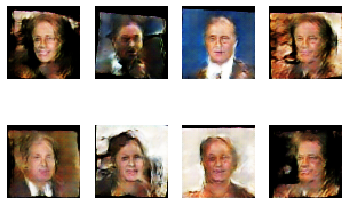

INFO:root:Epoch end. Total time for this epoch : 4.010559 (seconds)


In [22]:
counter = 0
for epoch in range(epochs + 1):
    logging.info("Epoch %s", epoch)
    starttime = time.time()
        
    for idx, data in enumerate(train_dataloader):
        batch_start_time = time.time()
        #get real data and the input to the generator.
        real_data = gluon.utils.split_and_load(data=data, ctx_list=ctx, even_split=False)
        generator_input = create_generator_input()
        
        ############################
        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        with autograd.record():
            output_real = [discriminator(d_) for d_ in real_data]
            d_error_real    = [loss(pred, label) for pred, label in zip(output_real, real_label)]
            error_real = 0
            for l_ in d_error_real:
                error_real += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
                # The division by len(ctx) is to average out the errors accross all the devices
            
            metric.update(real_label, output_real)
                
            # create fake image and input it to discriminator
            fake_image = [generator(g_) for g_ in generator_input]
            
            # We use detach() so that we don't update the Generator graph in this step.
            output_fake = [discriminator(f_image.detach()) for f_image in fake_image]
            d_error_fake = [loss(fake_pred, label) for fake_pred, label in zip(output_fake, fake_label)]     
            
            error_fake = 0
            for l_ in d_error_fake:
                error_fake += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
            
            metric.update(fake_label, output_fake)      
            
            total_d_error = error_real + error_fake
            # Backward pass on the error incurred in this step.
            for (loss_real, loss_fake) in zip(d_error_real, d_error_fake):
                l = loss_real + loss_fake
                l.backward()
                

        d_trainer.step(batch_size)

        ############################
        # (2) Update Generator network: maximize log(D(G(z)))
        ############################
        with autograd.record():
            fake_image = [generator(g_) for g_ in generator_input]
            output_fake = [discriminator(f_image) for f_image in fake_image]
            g_error = [loss(fake_pred, label) for fake_pred, label in zip(output_fake, real_label)]    
            total_g_error = 0
            for l_ in g_error:
                total_g_error += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
            
            # Backward pass on the error incurred in this step.
            for l_ in g_error:
                l_.backward()
                
        g_trainer.step(batch_size)

        # Print log infomation every 20 batches
        if idx % 20 == 0:
            count = idx + 1
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - batch_start_time)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' 
                     %(total_d_error,total_g_error, acc, count, epoch))
        btic = time.time()
        
    name, acc = metric.get()
    metric.reset()
    if epoch % 50 == 0:
        num_image = 8
        for i in range(num_image):
            latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
            img = generator(latent_z)
            plt.subplot(2,4,i+1)
            visualize(img[0])
        plt.show()
        
    logging.info('Epoch end. Total time for this epoch : %f (seconds)' %(time.time() - starttime))

We can save the model by calling `save_parameters` API.

In [23]:
discriminator.save_parameters('dcgan_discriminator_latest.params')
generator.save_parameters('dcgan_generator_latest.params')

The saved model can be loaded using `load_parameters` API. 
eg : 

```discriminator.load_parameters('infogan_d_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)```

After training the GAN, visualize to see what the Generator learnt and what it generates as a stand-alone network.

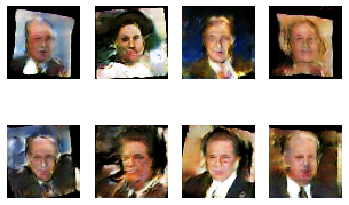

In [24]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
    img = generator(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

We can also interpolate linearly between points in latent space and can visualize the corresponding images. 
Small changes in latent space results in smooth changes in generated images.

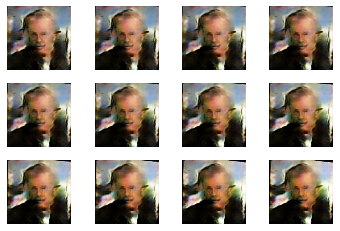

In [25]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
step = 0.05
for i in range(num_image):
    img = generator(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += step
plt.show()